<h1>Multiclass text classification of questions/description into subjects. Bag of words.</h1>

The goal of this project is to classify texts by 4 subjects - math, physic, chemistry and biology.

<h1>A note from a publisher of the data set</h2><br>
Here I am posting the link to the dataset. This dataset contains 3 columns. The goal is to classify the given texts into 4 subjects i.e Maths, Physics, Chemistry, and Biology.<br>
Challenges: Data Cleaning (contains random special characters, symbols, expressions which might contain class dependent information. Also carries latex formulas, mathematical functions, etc.),class imbalance. Customized NLP techniques (lemmatization, stemming, stop word removal must be carried out carefully to distinguish between classes.) Overfitting.<br>
Have a nice experience playing around with the data, community🤞.<br>
https://www.kaggle.com/mrutyunjaybiswal/iitjee-neet-aims-students-questions-data


<b>Context</b><br>
In India, every year lacs of students sit for competitive examinations like JEE Advanced, JEE Mains, NEET, etc. These exams are said to be the gateway to get admission into India's premier Institutes such as IITs, NITs, AIIMS, etc. Keeping in mind that the competition is tough as lacs of students appear for these examinations, there has been an enormous development in Ed Tech Industry in India, fortuning the dreams of lacs of aspirants via providing online as well as offline coaching, mentoring, etc. This particular dataset consists of questions/doubts raised by students preparing for such examinations.

<b>Content</b><br>
The dataset contains Students-questions.csv file in version 1 as of now.
Inside the CSV file, we have two columns:<br>
eng: The full question or description of the questions<br>
Subject: Which subject does the question belong to. It has 4 classes, Physics, Chemistry, Biology, and Mathematics.
So, it's basically an NLP problem where we have the question description and we need to find out which subject does this question belongs to.

<h2>Results</h2><br>
With 7 neighbors, train ROC 0.9875 and test ROC 0.9721.<br>
The math text might be easily confused with the physics text.<br>
High confusion between physics and chemistry.<br>
The least confusion happens between math and physics texts with biology texts.

<h2>EDA</h2>

In [1]:
# importing dependencies
from platform import python_version
import warnings

# for working with arrays and dataframes
import numpy as np
import pandas as pd

# for plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# for validation and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

# for working with text
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# for modelling
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# downloading libraries
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# showing versions
print('Python version:',python_version())
print('NumPy version:',np.__version__)
print('Pandas version:',pd.__version__)
print('NLTK version:',nltk.__version__)
print('Sklearn version:',sklearn.__version__)

Python version: 3.7.14
NumPy version: 1.21.6
Pandas version: 1.3.5
NLTK version: 3.7
Sklearn version: 1.0.2


In [4]:
# primary settings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None, 'display.max_columns', None)

In [5]:
# importing the dataset
df = pd.read_csv("subjects-questions.csv")
print(f"{df.shape[1]} columns, {df.shape[0]} rows")
# checking duplicated rows
print(f"{df.duplicated().sum()} duplicated rows")
print("Removing duplicated rows...")
df.drop_duplicates(inplace=True)
print(f"{df.duplicated().sum()} duplicated rows")
print(f"{df.shape[1]} columns, {df.shape[0]} rows")
df.head()

2 columns, 122519 rows
811 duplicated rows
Removing duplicated rows...
0 duplicated rows
2 columns, 121708 rows


,eng,Subject
0,An anti-forest measure is\nA. Afforestation\nB...,Biology
1,"Among the following organic acids, the acid pr...",Chemistry
2,If the area of two similar triangles are equal...,Maths
3,"In recent year, there has been a growing\nconc...",Biology
4,Which of the following statement\nregarding tr...,Physics


In [6]:
# renaming the columns
df.rename(columns={'eng': 'text', 'Subject': 'subject'}, inplace=True)
df = df[['subject', 'text']]
df.head()

,subject,text
0,Biology,An anti-forest measure is\nA. Afforestation\nB...
1,Chemistry,"Among the following organic acids, the acid pr..."
2,Maths,If the area of two similar triangles are equal...
3,Biology,"In recent year, there has been a growing\nconc..."
4,Physics,Which of the following statement\nregarding tr...


In [7]:
# seing the target
df.subject.value_counts(dropna=False) 

Physics      38128
Chemistry    37612
Maths        32874
Biology      13094
Name: subject, dtype: int64

In [8]:
# checking null values
print(df.isnull().values.any(axis=1).sum())

0


In [9]:
# printing data types
print(df.dtypes)

subject    object
text       object
dtype: object


In [10]:
# casting as string
df = df.astype(str)

In [11]:
# stripping
df['text'] = df['text'].str.strip()
df['subject'] = df['subject'].str.strip()

In [12]:
# tokenizing and removing short words
def tokenize(column):
    tokens = nltk.word_tokenize(column)
    return [w.lower().strip() for w in tokens if w.isalpha() and len(w) > 2]

# dividing words with hyphen
df['engineered_text'] = df['text'].str.replace('-', ' ')
df['engineered_text'] = df.apply(
    lambda x: tokenize(x['engineered_text']),axis=1)
df['engineered_text'].head()

0    [anti, forest, measure, afforestation, selecti...
1    [among, the, following, organic, acids, the, a...
2    [the, area, two, similar, triangles, are, equa...
3    [recent, year, there, has, been, growing, conc...
4    [which, the, following, statement, regarding, ...
Name: engineered_text, dtype: object

<h2>Feature Engineering</h2>

In [13]:
# lemmatization
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize(column):
    return [lemmatizer.lemmatize(w) for w in column]

df['engineered_text'] = \
    df.apply(lambda x: lemmatize(x['engineered_text']), axis=1)
df['engineered_text'].head()

0    [anti, forest, measure, afforestation, selecti...
1    [among, the, following, organic, acid, the, ac...
2    [the, area, two, similar, triangle, are, equal...
3    [recent, year, there, ha, been, growing, conce...
4    [which, the, following, statement, regarding, ...
Name: engineered_text, dtype: object

In [14]:
# printing NLTK stop words
stop_words = stopwords.words('english')
# removing frequent scientific words
stop_words += [
    'reason', 'correct', 'incorrect', 'true', 'false', 'assertion', 'given',
    'following', 'increase', 'decrease','zero', 'one', 'two', 'three', 'four',
    'first', 'second', 'third', 'fours', 'none', 'called', 'find', 'found',
    'ccc', 'iii', 'lll', 'ha', 'le', 'occur', 'multiple', 'option', 'figure',
    'help', 'aid', 'part', 'give', 'take', 'question', 'answer', 'occur',
    'consistent', 'different', 'due', 'form', 'many', 'done', 'used', 'change',
    'name', 'shown', 'statement', 'ratio', 'calculate', 'respectively',
    'explanation', 'choose', 'occurs', 'show', 'another', 'become', 'doe',
    'block', 'anti', 'pro', 'contain', 'known', 'small', 'big', 'large', 'end',
    'process', 'must', 'difference', 'explain']
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [15]:
# excluding stop words from "description_tokenized"
df['engineered_text'] = df.engineered_text.apply(lambda x: ' '.join([
    word for word in x if word not in stop_words]))
df.head()

,subject,text,engineered_text
0,Biology,An anti-forest measure is\nA. Afforestation\nB...,forest measure afforestation selective grazing...
1,Chemistry,"Among the following organic acids, the acid pr...",among organic acid acid present rancid butter ...
2,Maths,If the area of two similar triangles are equal...,area similar triangle equal equilateral isosce...
3,Biology,"In recent year, there has been a growing\nconc...",recent year growing concern gradually increasi...
4,Physics,Which of the following statement\nregarding tr...,regarding transformer transformer make use far...


Biology


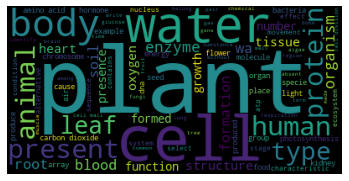

Chemistry


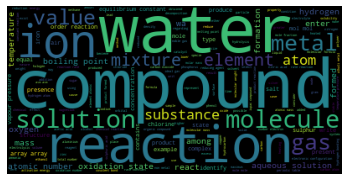

Maths


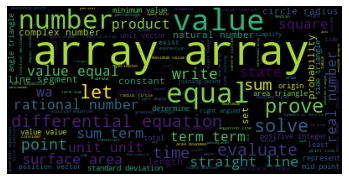

Physics


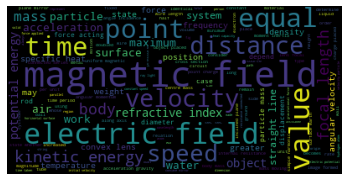

In [16]:
# plotting the WordCloud for each category                   
for sbj in df['subject'].unique():
    print(sbj)
    srting_of_words = ' '.join(df['engineered_text'][df['subject'] == sbj])
    word_cloud = WordCloud().generate(srting_of_words)
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()

<h2>Validation</h2>

In [17]:
# splitting to train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.engineered_text,
    df.subject, test_size=0.15, random_state=42, stratify=df.subject)

print(f"X_train shape: {X_train.shape}\n")
print(f"X_test shape: {X_test.shape}\n")
print(f"y_train:\n{y_train.value_counts(dropna=False)}\n")
print(f"y_test:\n{y_test.value_counts(dropna=False)}")

X_train shape: (103451,)

X_test shape: (18257,)

y_train:
Physics      32408
Chemistry    31970
Maths        27943
Biology      11130
Name: subject, dtype: int64

y_test:
Physics      5720
Chemistry    5642
Maths        4931
Biology      1964
Name: subject, dtype: int64


In [18]:
# encoding y_train
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [19]:
# vectorization
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)

# TF-IDF encoding
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [20]:
# trying KNN classifier with varuous n_neighbors
column_names = ['neighbors', 'train roc', 'test roc']
score_table = pd.DataFrame(columns = column_names)

for n_neighbors in range(1, 12, 2):

    # defining KNN classifier
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric='cosine')

    # training the classifier
    clf = knn.fit(X_train_tfidf, y_train)

    # predicting
    y_pred = clf.predict(X_test_tfidf)
    y_train_proba = clf.predict_proba(X_train_tfidf)
    y_test_proba = clf.predict_proba(X_test_tfidf)

    # ROC-AUC scoring
    train_roc_auc_ovr = roc_auc_score(y_train, y_train_proba, multi_class="ovr",
                                      average="weighted")
    test_roc_auc_ovr = roc_auc_score(y_test, y_test_proba, multi_class="ovr",
                                     average="weighted")
    print(f"n_neighbors {n_neighbors}")
    print(f"One-vs-Rest weighted ROC AUC train score {train_roc_auc_ovr:.4f}")
    print(f"One-vs-Rest weighted ROC AUC test score {test_roc_auc_ovr:.4f}")
    print()

    score_table = score_table.append({'neighbors': n_neighbors,
        'train roc': train_roc_auc_ovr, 'test roc': test_roc_auc_ovr},
        ignore_index=True)

n_neighbors 1
One-vs-Rest weighted ROC AUC train score 0.9781
One-vs-Rest weighted ROC AUC test score 0.9080

n_neighbors 3
One-vs-Rest weighted ROC AUC train score 0.9925
One-vs-Rest weighted ROC AUC test score 0.9607

n_neighbors 5
One-vs-Rest weighted ROC AUC train score 0.9897
One-vs-Rest weighted ROC AUC test score 0.9683

n_neighbors 7
One-vs-Rest weighted ROC AUC train score 0.9875
One-vs-Rest weighted ROC AUC test score 0.9712

n_neighbors 9
One-vs-Rest weighted ROC AUC train score 0.9867
One-vs-Rest weighted ROC AUC test score 0.9731

n_neighbors 11
One-vs-Rest weighted ROC AUC train score 0.9847
One-vs-Rest weighted ROC AUC test score 0.9734



In [21]:
score_table

,neighbors,train roc,test roc
0,1.0,0.978107,0.908000
1,3.0,0.992481,0.960712
2,5.0,0.989684,0.968326
3,7.0,0.987521,0.971232
4,9.0,0.986675,0.973087
5,11.0,0.984693,0.973426


(0.9, 1.0)

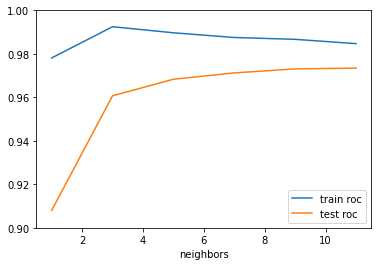

In [22]:
score_table.plot(x='neighbors', y=['train roc', 'test roc'], kind='line',
                 figsize=(6, 4));
plt.ylim([0.9, 1.0])

<h2>Modeling</h2>

n_neighbors 7
One-vs-Rest weighted ROC AUC train score 0.9875
One-vs-Rest weighted ROC AUC test score 0.9712

Accuracy per class
['Biology' 'Chemistry' 'Maths' 'Physics']
[0.78360489 0.87788018 0.88359359 0.87237762]

Biology:1539/1964
Chemistry:4953/5642
Maths:4357/4931
Physics:4990/5720



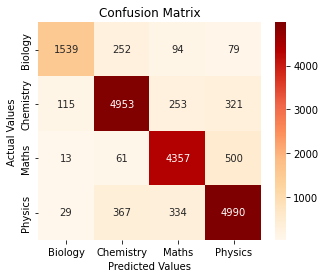

In [23]:
# defining KNN classifier
n_neighbors = 7
knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric='cosine')

# training the classifier
clf = knn.fit(X_train_tfidf, y_train)

# predicting
y_pred = clf.predict(X_test_tfidf)
y_train_proba = clf.predict_proba(X_train_tfidf)
y_test_proba = clf.predict_proba(X_test_tfidf)

# ROC-AUC scoring
train_roc_auc_ovr = roc_auc_score(y_train, y_train_proba, multi_class="ovr",
                                  average="weighted")
test_roc_auc_ovr = roc_auc_score(y_test, y_test_proba, multi_class="ovr",
                                 average="weighted")
print(f"n_neighbors {n_neighbors}")
print(f"One-vs-Rest weighted ROC AUC train score {train_roc_auc_ovr:.4f}")
print(f"One-vs-Rest weighted ROC AUC test score {test_roc_auc_ovr:.4f}")
print()

# calculaiton confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=encoder.classes_, columns=encoder.classes_)

print("Accuracy per class")
print(encoder.classes_)
print(cm.diagonal()/cm.sum(axis=1))
print()
for idx in range(len(cm)):
    print(f"{encoder.classes_[idx]}:{cm.diagonal()[idx]}/{cm.sum(axis=1)[idx]}")
print()

# plotting the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_df, annot=True, cmap="OrRd", fmt=".0f")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

<h2>Discussion</h2>

With 7 neighbors, train ROC 0.9875 and test ROC 0.9721.<br>
The math text might be easily confused with the physics text.<br>
High confusion between physics and chemistry.<br>
The least confusion happens between math and physics texts with biology texts.